## Setup & Imports

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import sys
import os
import pandas as pd
import numpy as np
import warnings

In [61]:
sys.path.append(os.path.abspath('..'))

import src.config as cfg
from src.preprocessing import DataPreprocessor
from src.encoders import GlobalEncoder
from src.segmentation import SegmentManager
from src.modeling import ModelTrainer
from src.evaluation import ModelEvaluator
from src.interpretation import ShapAnalyzer
from src.deploy import ModelDeployer

In [62]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Data Loading

In [63]:
print(f"Loading data from: {cfg.DATA_PATH}")

Loading data from: dataset/


In [64]:
df_train = pd.read_csv(os.path.join('..', cfg.DATA_PATH, cfg.TRAIN_FILE))
df_test = pd.read_csv(os.path.join('..', cfg.DATA_PATH, cfg.TEST_FILE))

In [65]:
print(f"Train shape: {df_train.shape}")
print(f"Test shape:  {df_test.shape}")

Train shape: (103904, 25)
Test shape:  (25976, 25)


In [66]:
df_train.head(3)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied


## Global Preprocessing

In [67]:
dp = DataPreprocessor()

In [68]:
cfg.ID_COLS

['Unnamed: 0', 'id']

In [69]:
df_train = dp.drop_columns(df_train, cfg.ID_COLS)
df_test = dp.drop_columns(df_test, cfg.ID_COLS)

Dropped columns: ['Unnamed: 0', 'id']
Dropped columns: ['Unnamed: 0', 'id']


In [70]:
cfg.DELAY_INPUT_COLS

['Departure Delay in Minutes', 'Arrival Delay in Minutes']

In [71]:
df_train = dp.fill_na(df_train, cfg.DELAY_INPUT_COLS, value=0)
df_test = dp.fill_na(df_test, cfg.DELAY_INPUT_COLS, value=0)

Filled NaNs with 0 in 1 columns.
Filled NaNs with 0 in 1 columns.


In [72]:
# df_train = dp.transform_log_sum(df_train, cfg.DELAY_INPUT_COLS, cfg.DELAY_OUTPUT_COL, drop_input=True)
# df_test = dp.transform_log_sum(df_test, cfg.DELAY_INPUT_COLS, cfg.DELAY_OUTPUT_COL, drop_input=True)

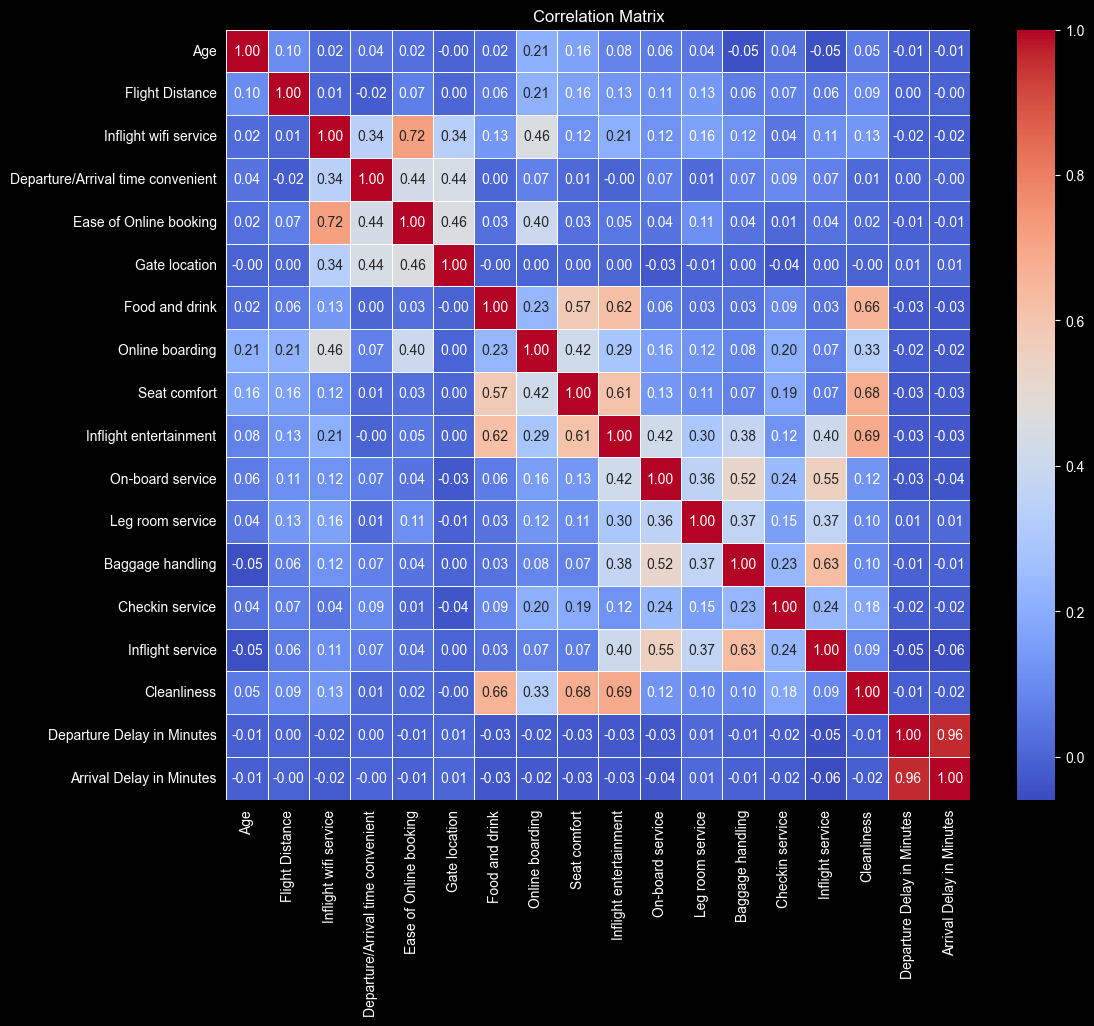

In [73]:
dp.plot_correlation(df_train)

In [74]:
df_train = dp.create_feature(df_train,
                             output_col='Arrival Delay Log',
                             func=lambda df: np.log1p(1 + df['Arrival Delay in Minutes']))
df_test = dp.create_feature(df_test,
                             output_col='Arrival Delay Log',
                             func=lambda df: np.log1p(1 + df['Arrival Delay in Minutes']))

Feature created: 'Arrival Delay Log'
Feature created: 'Arrival Delay Log'


In [75]:
df_train = dp.create_feature(df_train,
                             output_col='Time Saved In Air',
                             func=lambda df: df['Departure Delay in Minutes'] - df['Arrival Delay in Minutes'])
df_test = dp.create_feature(df_test,
                             output_col='Time Saved In Air',
                             func=lambda df: df['Departure Delay in Minutes'] - df['Arrival Delay in Minutes'])

Feature created: 'Time Saved In Air'
Feature created: 'Time Saved In Air'


In [76]:
df_train = dp.drop_columns(df_train, ['Departure Delay in Minutes', 'Arrival Delay in Minutes'])
df_test = dp.drop_columns(df_test, ['Departure Delay in Minutes', 'Arrival Delay in Minutes'])

Dropped columns: ['Departure Delay in Minutes', 'Arrival Delay in Minutes']
Dropped columns: ['Departure Delay in Minutes', 'Arrival Delay in Minutes']


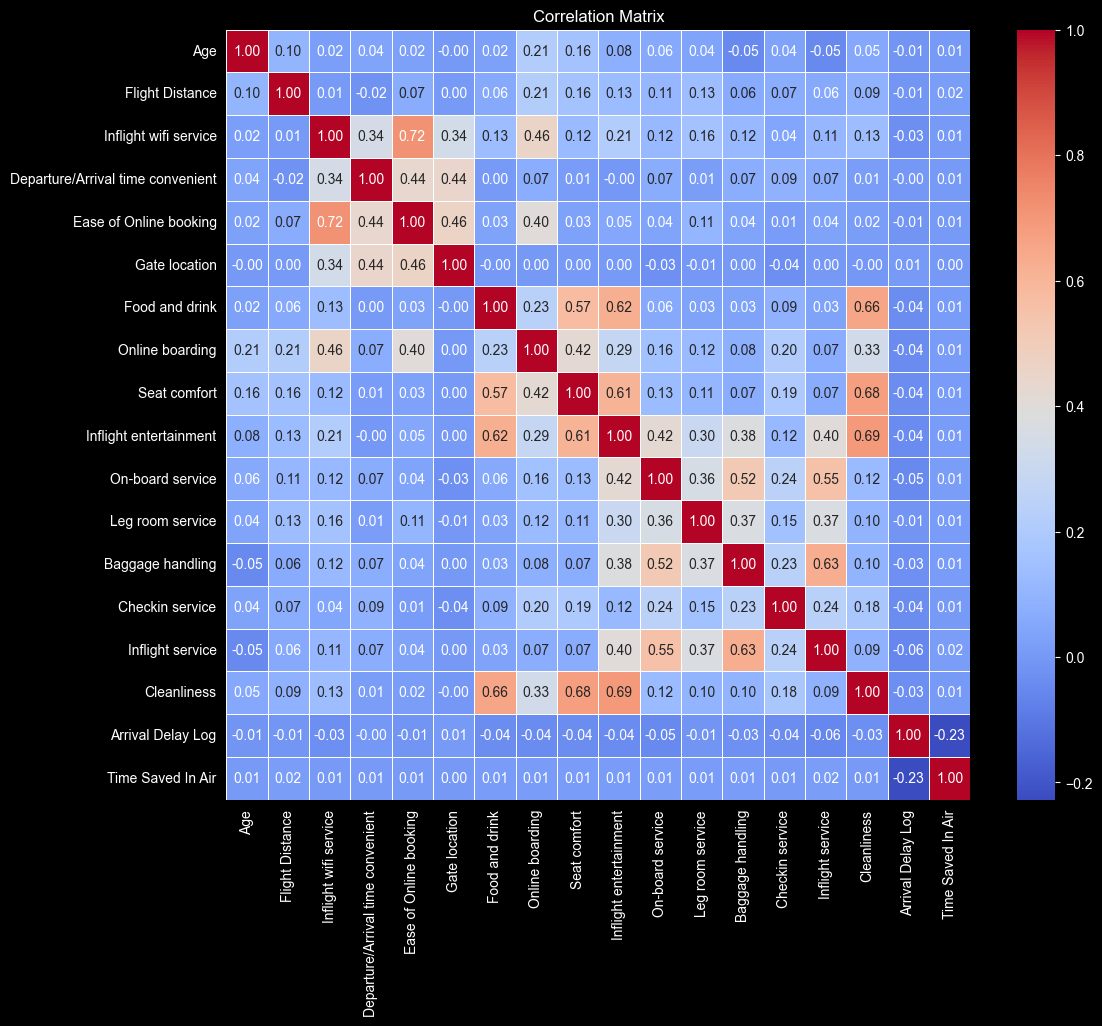

In [77]:
dp.plot_correlation(df_train)

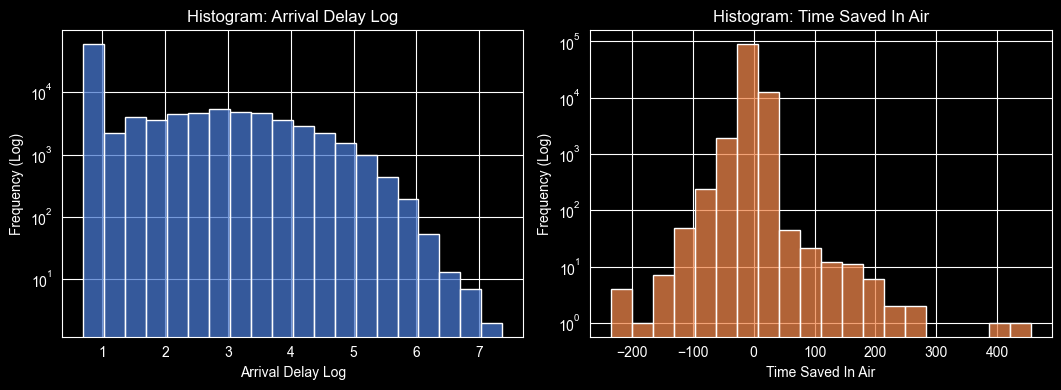

In [78]:
dp.plot_histograms(df_train, ['Arrival Delay Log', 'Time Saved In Air'], log_y=True)

In [79]:
cfg.SERVICE_COLS

['Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness']

In [80]:
zero_stats = dp.analyze_zeros(df_train, columns=cfg.SERVICE_COLS)


=== Zero Values Analysis ===
                                   Zeros Count  Zeros %
Departure/Arrival time convenient         5300     5.10
Ease of Online booking                    4487     4.32
Inflight wifi service                     3103     2.99
Online boarding                           2428     2.34
Leg room service                           472     0.45
Food and drink                             107     0.10
Inflight entertainment                      14     0.01
Cleanliness                                 12     0.01
Gate location                                1     0.00
Seat comfort                                 1     0.00
On-board service                             3     0.00
Checkin service                              1     0.00
Inflight service                             3     0.00

Total columns checked: 14


Cleaning noise (rows with invalid zeros)

In [81]:
columns_to_drop = ['Inflight entertainment',
                   'Food and drink',
                   'Cleanliness',
                   'Gate location',
                   'Seat comfort',
                   'On-board service',
                   'Checkin service',
                   'Inflight service']

In [82]:
df_train = dp.drop_rows_with_by_value(df_train, columns=columns_to_drop, drop_value=0)
df_test = dp.drop_rows_with_by_value(df_test, columns=columns_to_drop, drop_value=0)

Dropped 112 rows (0.11%) containing 0s.
Dropped 27 rows (0.10%) containing 0s.


In [83]:
columns_to_replace_zeros = [col for col in cfg.SERVICE_COLS if not col in columns_to_drop ]
columns_to_replace_zeros

['Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Online boarding',
 'Leg room service',
 'Baggage handling']

In [84]:
df_train = dp.replace_values(df_train,
                             columns_to_replace_zeros,
                             old_value=0,
                             new_value=np.nan)
df_test = dp.replace_values(df_test,
                            columns_to_replace_zeros,
                            old_value=0,
                            new_value=np.nan)

Replaced '0' with 'nan' in 5 columns.
Replaced '0' with 'nan' in 5 columns.


## Visualizing the need for segmentation

In [85]:
# for col in df_train.columns:
#     dp.plot_interaction_evidence(
#         df_train,
#         x_col=col,
#         target_col=cfg.TARGET_COL,
#         group_col='Type of Travel'
#     )

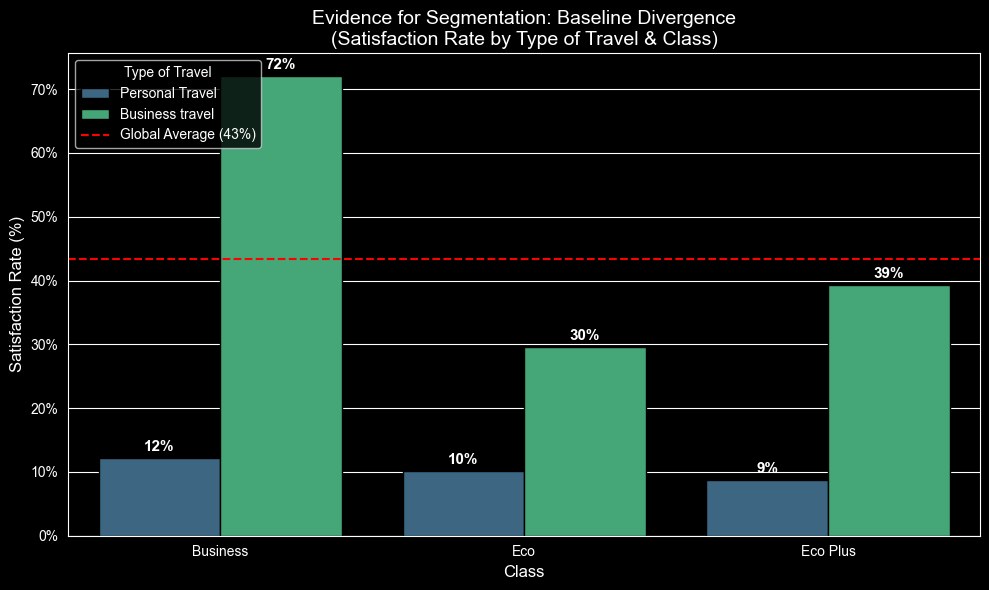

In [86]:
dp.plot_baseline_divergence(
    df_train,
    class_col='Class',
    type_col='Type of Travel',
    target_col=cfg.TARGET_COL
)

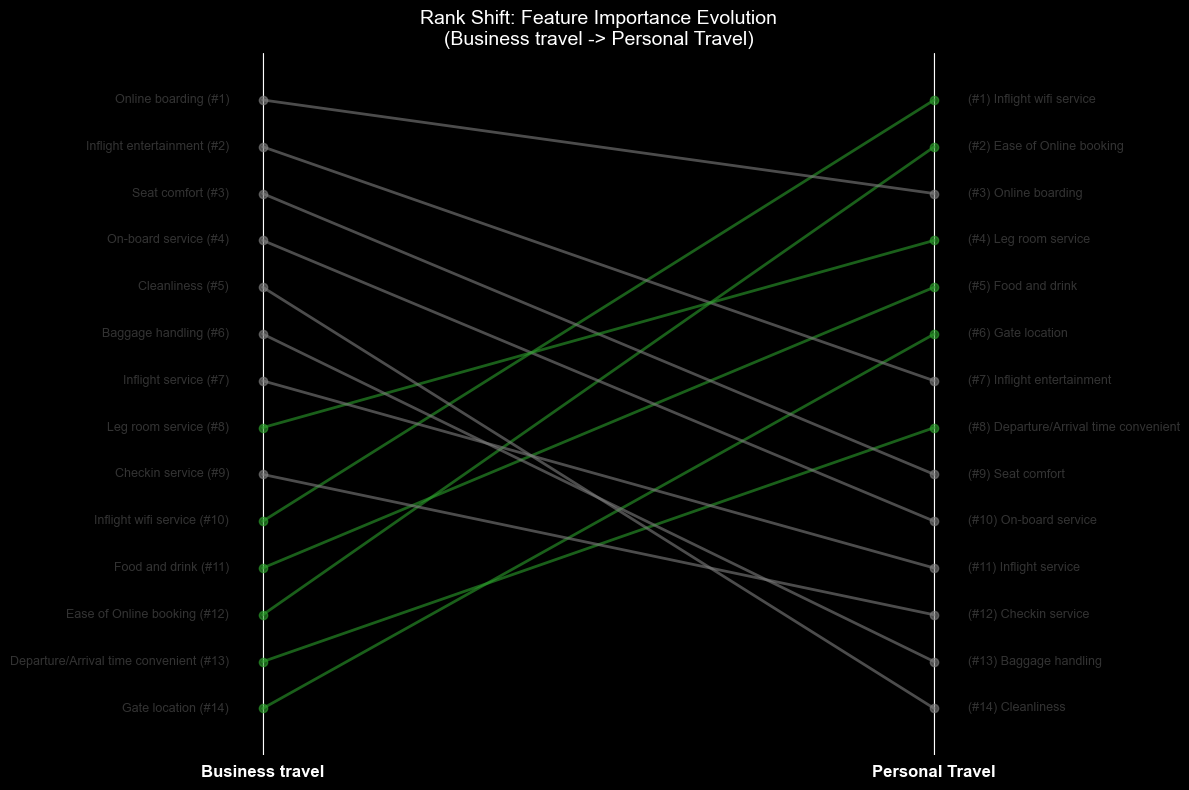

In [87]:
dp.plot_rank_shift(
    df_train,
    service_cols=cfg.SERVICE_COLS,
    target_col=cfg.TARGET_COL,
    group_col='Type of Travel',
    top_n=10
)

In [88]:
_, num_col, _ = dp.get_metadata(df_train)

In [89]:
num_col

['Age',
 'Flight Distance',
 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness',
 'Arrival Delay Log',
 'Time Saved In Air']

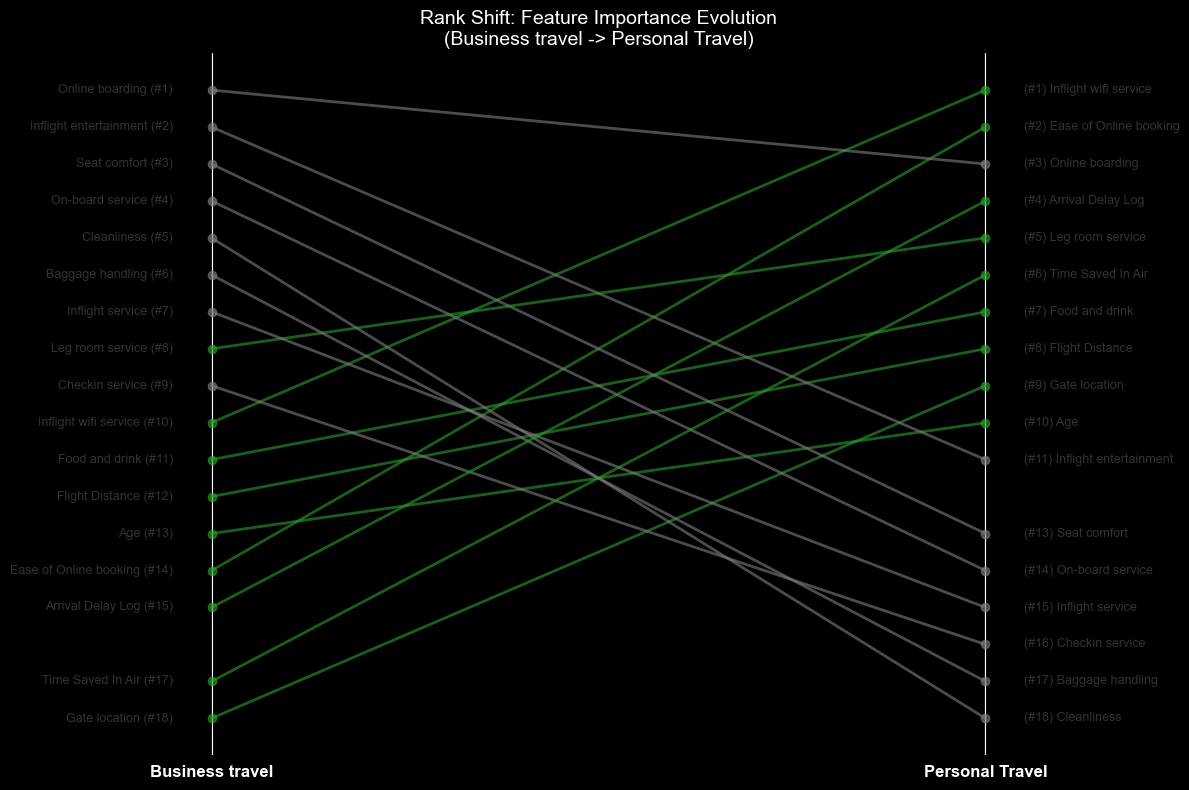

In [90]:
dp.plot_rank_shift(
    df_train,
    service_cols=num_col,
    target_col=cfg.TARGET_COL,
    group_col='Type of Travel',
    top_n=10
)

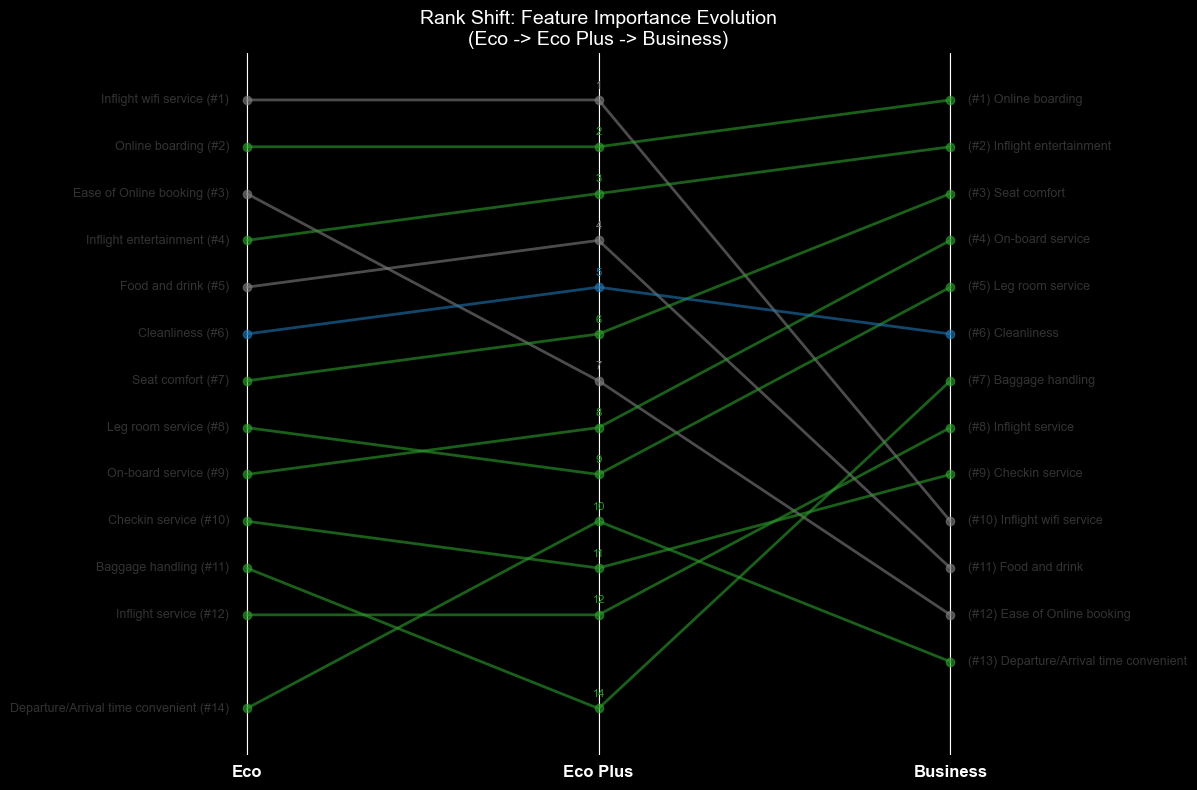

In [91]:
dp.plot_rank_shift(
    df_train,
    service_cols=cfg.SERVICE_COLS,
    target_col=cfg.TARGET_COL,
    group_col='Class',
    group_order=['Eco', 'Eco Plus', 'Business'],
    top_n=10
)

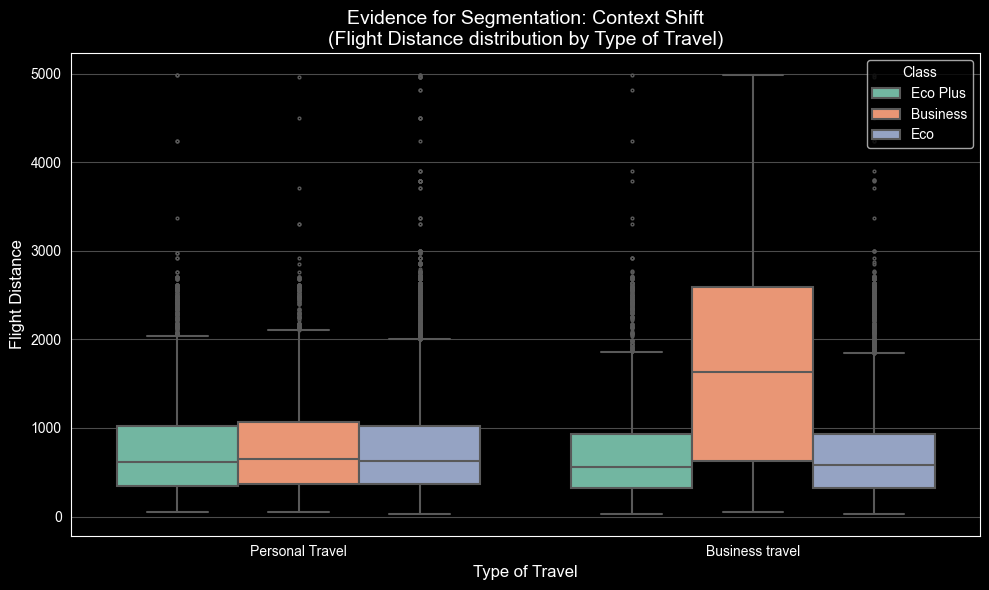

In [92]:
dp.plot_distribution_shift(
    df_train,
    feature_col='Flight Distance',
    group_col='Type of Travel',
    hue_col='Class'
)

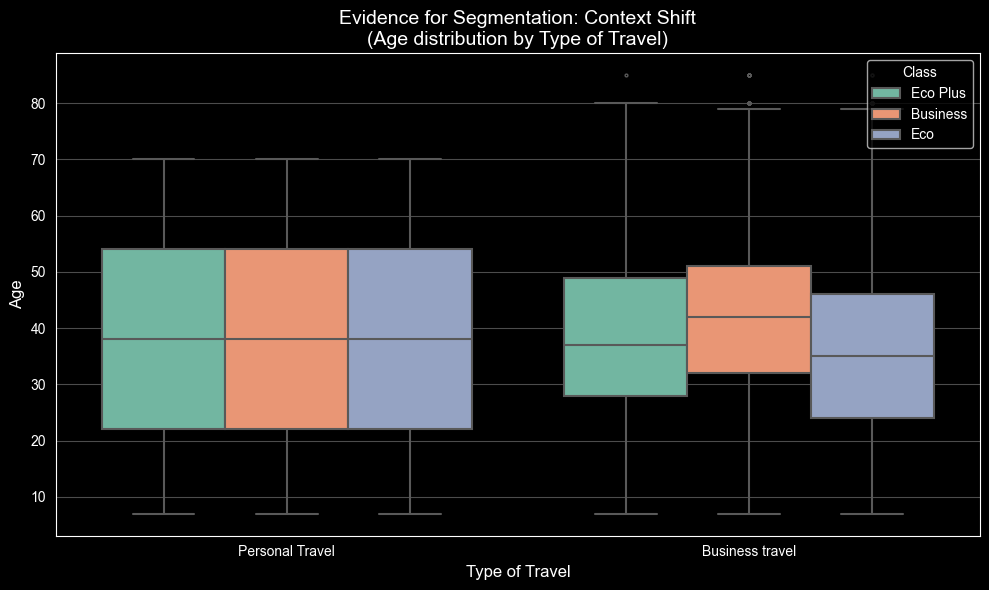

In [93]:
dp.plot_distribution_shift(
    df_train,
    feature_col='Age',
    group_col='Type of Travel',
    hue_col='Class'
)

## Global Encoding

In [96]:
cfg.ENCODER_MANUAL_CONFIG

{'Class': {'Map': {'Eco': 0, 'Eco Plus': 1, 'Business': 2},
  'Suffix': '_Encoded'}}

In [97]:
cfg.AUTO_ENCODING_COLS

['Gender', 'Customer Type', 'Type of Travel']

In [98]:
encoder = GlobalEncoder(
    manual_mappings=cfg.ENCODER_MANUAL_CONFIG,
    auto_cols=cfg.AUTO_ENCODING_COLS
)

[autoreload of src.config failed: Traceback (most recent call last):
  File "C:\Users\Admin\Desktop\Segmented-Drivers-of-Airline-Satisfaction\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "C:\Users\Admin\Desktop\Segmented-Drivers-of-Airline-Satisfaction\.venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 546, in maybe_reload_module
    new_source_code = f.read()
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python314\Lib\encodings\cp1251.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x98 in position 163: character maps to <undefined>
]


In [99]:
df_train.head(5)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction,Arrival Delay Log,Time Saved In Air
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3.0,4.0,3.0,1,5,3.0,5,5,4,3.0,4,4,5,5,neutral or dissatisfied,2.995732,7.0
1,Male,disloyal Customer,25,Business travel,Business,235,3.0,2.0,3.0,3,1,3.0,1,1,1,5.0,3,1,4,1,neutral or dissatisfied,2.079442,-5.0
2,Female,Loyal Customer,26,Business travel,Business,1142,2.0,2.0,2.0,2,5,5.0,5,5,4,3.0,4,4,4,5,satisfied,0.693147,0.0
3,Female,Loyal Customer,25,Business travel,Business,562,2.0,5.0,5.0,5,2,2.0,2,2,2,5.0,3,1,4,2,neutral or dissatisfied,2.397895,2.0
4,Male,Loyal Customer,61,Business travel,Business,214,3.0,3.0,3.0,3,4,5.0,5,3,3,4.0,4,3,3,3,satisfied,0.693147,0.0


In [100]:
df_train = encoder.fit_transform(df_train)
df_test = encoder.transform(df_test)

GlobalEncoder fitted on 3 auto-columns.
Created column 'Class_Encoded' using manual mapping.
Created column 'Class_Encoded' using manual mapping.


In [101]:
df_train.head(5)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction,Arrival Delay Log,Time Saved In Air,Class_Encoded
0,1,0,13,1,Eco Plus,460,3.0,4.0,3.0,1,5,3.0,5,5,4,3.0,4,4,5,5,neutral or dissatisfied,2.995732,7.0,1
1,1,1,25,0,Business,235,3.0,2.0,3.0,3,1,3.0,1,1,1,5.0,3,1,4,1,neutral or dissatisfied,2.079442,-5.0,2
2,0,0,26,0,Business,1142,2.0,2.0,2.0,2,5,5.0,5,5,4,3.0,4,4,4,5,satisfied,0.693147,0.0,2
3,0,0,25,0,Business,562,2.0,5.0,5.0,5,2,2.0,2,2,2,5.0,3,1,4,2,neutral or dissatisfied,2.397895,2.0,2
4,1,0,61,0,Business,214,3.0,3.0,3.0,3,4,5.0,5,3,3,4.0,4,3,3,3,satisfied,0.693147,0.0,2


In [102]:
cfg.TARGET_MAP

{'neutral or dissatisfied': 0, 'satisfied': 1}

In [103]:
df_train[cfg.TARGET_COL] = df_train[cfg.TARGET_COL].map(cfg.TARGET_MAP)
df_test[cfg.TARGET_COL] = df_test[cfg.TARGET_COL].map(cfg.TARGET_MAP)

In [104]:
print("Encoding complete. Example data:")
df_train[['Class', 'Class_Encoded', 'Type of Travel', 'Gender']].head()

Encoding complete. Example data:


,Class,Class_Encoded,Type of Travel,Gender
0,Eco Plus,1,1,1
1,Business,2,0,1
2,Business,2,0,0
3,Business,2,0,0
4,Business,2,0,1


## The Core Loop: Segmentation -> Modeling -> Analysis

In [ ]:
seg_manager = SegmentManager(cfg.SEGMENT_CONFIGS, cfg.TARGET_COL, min_samples=cfg.MIN_SEGMENT_SIZE)
trainer = ModelTrainer(fixed_params=cfg.XGB_FIXED_PARAMS, random_state=cfg.RANDOM_STATE)
evaluator = ModelEvaluator()
deployer = ModelDeployer(base_path="artifacts")

In [ ]:
from src.pipeline import TrainingPipeline

pipeline = TrainingPipeline(trainer, evaluator, deployer)

In [ ]:
all_metrics = {}

In [ ]:
for data in seg_manager.iterate_segments(df_train, df_test):

    metrics = pipeline.run_segment(data)

    if metrics:
        all_metrics[data['name']] = metrics

## Final Comparison & Outcomes

In [ ]:
print("\n=== FINAL COMPARISON ===")
df_results = ModelEvaluator.compare_segments(all_metrics)

df_results.to_csv("artifacts/reports/final_comparison.csv")

display(df_results.style.background_gradient(cmap='Greens'))